In [1]:
%matplotlib notebook

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import os
import glob
import calendar
import re

In [20]:
def read_precip(fili):
    """
    Reader for precipitation files contained in the NPSNOW data set

    In NPSNOW precip files, dry-days have amount=-9.9 and type=-9.
    These are set to 0.0 and 0 respectively.  This dry-days are distinct
    from days with trace precipitation, which have amount 0.0 and non-zero 
    type.

    Arguments
    ---------
    fili - file path

    Returns
    -------
    Pandas dataframe containg precipitation data for one station
    """

    df = pd.read_csv(fili, header=None, delim_whitespace=True,
                     #na_values={'amount': -9.9, 'type': -9}, 
                     names=['statid','month','day','year','amount','type'])

    isday = [row[1]['day'] <= \
             calendar.monthrange( int(row[1]['year']),int(row[1]['month']) )[1] \
             for row in df.iterrows()]
    df = df[isday] # only return rows with valid date

    df.index = [dt.datetime(int(row[1]['year']),
                            int(row[1]['month']),
                            int(row[1]['day']) ) \
                for row in df.iterrows()] # Reset index to date

    # Assumes zero precipitation/dry days are marked as -9.9, set to zero
    df = df.where(df > 0., 0.0)
    
    return df[['statid','amount','type']]


Get files containing precipitation.  Following Bogdanova et al (2006), I exclude NP 4, 5 and 14

In [74]:
dirpath = r'C:\Users\apbarret\Documents\data\SnowOnSeaIce\NPSNOW\precip'
filelist = glob.glob(os.path.join(dirpath,'np_??_??.pre'))
filelist = [f for f in filelist if not re.search('np_03|np_04|np_14',f)]
filelist

['C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_05_55.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_05_56.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_06_56.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_06_57.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_06_58.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_06_59.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_07_57.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_07_58.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_07_59.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_08_61.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\precip\\np_08_62.pre',
 'C:\\Users\\apbarret\\Documents\\data\\SnowOnSeaIce\\NPSNOW\\pre

In [75]:
df = pd.concat([read_precip(f) for f in filelist])
df.head()

statid  amount  type
1955-05-01       5     0.0     0
1955-05-02       5     0.0     0
1955-05-03       5     0.0     0
1955-05-04       5     0.0     0
1955-05-05       5     0.0     0

## Subset to 1979 onwards

## Find number of observations in each month for 1979 to 1991 period

In [46]:
df_sub = df.loc['1979':]
df_sub.groupby(df_sub.index.month).count()

statid  amount  type
1      713     713   713
2      651     651   651
3      682     682   682
4      570     570   570
5      558     558   558
6      600     600   600
7      682     682   682
8      682     682   682
9      660     660   660
10     682     682   682
11     660     660   660
12     682     682   682

In [43]:
bins = np.arange(1,30,1)
count, x = np.histogram(precip, bins=bins)
print (count)
print(x)

[1790  557  243  118   63   52   25   28   13   10   12    3    2    4
    0    0    1    0    0    1    0    0    1    2    0    0    0    1]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


0.4336302731355371


<IPython.core.display.Javascript object>


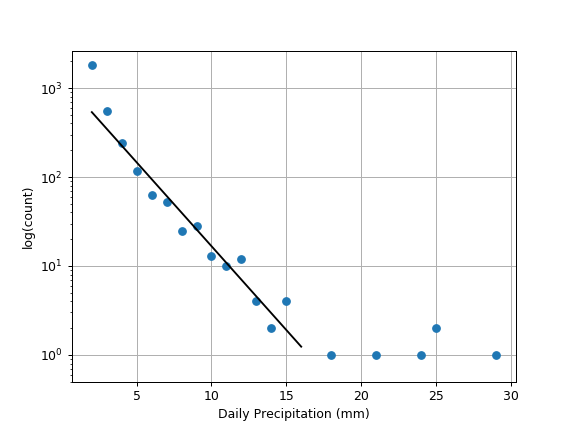

(0.5, 2629.093673969268)

In [55]:
total = count.sum()
p = 1/precip.mean()
print (p)
count_hat = total * p * np.exp(-p*x[1:])
xhat = x[1:][count_hat >= 1]
count_hat = count_hat[count_hat >= 1]

fig, ax = plt.subplots()

ax.semilogy(x[1:], count, 'o')
ax.semilogy(xhat, count_hat, '-k')
ax.grid(True)
ax.set_ylabel('log(count)')
ax.set_xlabel('Daily Precipitation (mm)')
ax.set_ylim(0.5,)

## Recreate Bogdanova et al 2006 Table 4

In [51]:
# Subset to include only NP-5 onwards
dfb = df.loc[df.statid >= 5]
dfb.head()

statid  amount  type
1955-05-01       5     0.0     0
1955-05-02       5     0.0     0
1955-05-03       5     0.0     0
1955-05-04       5     0.0     0
1955-05-05       5     0.0     0

In [59]:
# Generate table organized by index time and station
table = pd.pivot_table(dfb, values='amount', index=dfb.index, columns='statid')
table = table.resample('MS').sum() # Generate month sums
table = table.where(table > 0) # Set zero to NaN
table.head()

statid        5   6   7   8   9   10  11  12  13  14 ...  22  23  24  25  26  \
1955-05-01   1.3 NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN NaN NaN NaN   
1955-06-01   7.2 NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN NaN NaN NaN   
1955-07-01  13.7 NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN NaN NaN NaN   
1955-08-01  27.6 NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN NaN NaN NaN   
1955-09-01  12.3 NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN NaN NaN NaN NaN   

statid      27  28  29  30  31  
1955-05-01 NaN NaN NaN NaN NaN  
1955-06-01 NaN NaN NaN NaN NaN  
1955-07-01 NaN NaN NaN NaN NaN  
1955-08-01 NaN NaN NaN NaN NaN  
1955-09-01 NaN NaN NaN NaN NaN  

[5 rows x 27 columns]

In [66]:
table.loc['1961']

statid      5   6   7     8    9     10  11  12  13  14 ...  22  23  24  25  \
1961-01-01 NaN NaN NaN   NaN  6.3   NaN NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-02-01 NaN NaN NaN   NaN  3.3   NaN NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-03-01 NaN NaN NaN   NaN  0.4   NaN NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-04-01 NaN NaN NaN   NaN  NaN   NaN NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-05-01 NaN NaN NaN   4.0  NaN   NaN NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-06-01 NaN NaN NaN   9.6  NaN   NaN NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-07-01 NaN NaN NaN  33.8  NaN   NaN NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-08-01 NaN NaN NaN   8.8  NaN   NaN NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-09-01 NaN NaN NaN   5.9  NaN   NaN NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-10-01 NaN NaN NaN  10.6  NaN   NaN NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-11-01 NaN NaN NaN  10.0  NaN  32.5 NaN NaN NaN NaN ... NaN NaN NaN NaN   
1961-12-01 NaN NaN NaN   5.9  NaN   3.9 NaN NaN NaN NaN ... NaN NaN NaN NaN   

statid      26  27  28  29  30  31  
1961-01-01 NaN NaN NaN NaN NaN NaN  
1961-02-01 NaN NaN NaN NaN NaN NaN  
1961-03-01 NaN NaN NaN NaN NaN NaN  
1961-04-01 NaN NaN NaN NaN NaN NaN  
1961-05-01 NaN NaN NaN NaN NaN NaN  
1961-06-01 NaN NaN NaN NaN NaN NaN  
1961-07-01 NaN NaN NaN NaN NaN NaN  
1961-08-01 NaN NaN NaN NaN NaN NaN  
1961-09-01 NaN NaN NaN NaN NaN NaN  
1961-10-01 NaN NaN NaN NaN NaN NaN  
1961-11-01 NaN NaN NaN NaN NaN NaN  
1961-12-01 NaN NaN NaN NaN NaN NaN  

[12 rows x 27 columns]

In [63]:
table.count(axis=1).resample('Y').sum()

1955-12-31     8
1956-12-31    16
1957-12-31    20
1958-12-31    24
1959-12-31    11
1960-12-31     8
1961-12-31    13
1962-12-31    23
1963-12-31    24
1964-12-31    24
1965-12-31    24
1966-12-31    21
1967-12-31    16
1968-12-31    19
1969-12-31    26
1970-12-31    33
1971-12-31    39
1972-12-31    28
1973-12-31    18
1974-12-31    16
1975-12-31    12
1976-12-31    23
1977-12-31    24
1978-12-31    29
1979-12-31    24
1980-12-31    22
1981-12-31    19
1982-12-31    15
1983-12-31    19
1984-12-31    21
1985-12-31    12
1986-12-31    19
1987-12-31    24
1988-12-31    29
1989-12-31    24
1990-12-31    24
1991-12-31     5
Freq: A-DEC, dtype: int64